## Import Library

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import difflib

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score

## Get Data

---

In [2]:
# get csv files of player stats and salary
salary_df = pd.read_csv('nba_salary_ESPN_cleaned.csv')
player_df = pd.read_csv('nba_player_stats_official.csv')

In [3]:
# convert year by taking first 4 char of year feature
# i.e. 2019-20 will be 2019 now
player_df['year'] = player_df['year'].apply(lambda x: x[:4]).astype(int)

# convert year by subtracting year by 2
# i.e. 2020 will be 2018 now
salary_df['year'] = salary_df['year'].apply(lambda x: x - 2).astype(int)

In [4]:
# get close match for each name in salary dataframe with player dataframe
player_name = player_df['PLAYER_NAME'].unique()
salary_df['name_close_match'] = salary_df['NAME'].apply(
    lambda x: (difflib.get_close_matches(x, player_name)[:1] or [None])[0])

In [5]:
# inner join salary and player stats by player name and year
df = player_df.merge(salary_df, how = 'inner', 
                     left_on=['PLAYER_NAME','year'], right_on = ['name_close_match','year'])

In [6]:
# get data shape
df.shape

(7926, 71)

## EDA

---

In [7]:
# get stats of salary
df.SALARY.describe()

count    7.926000e+03
mean     5.403477e+06
std      5.944172e+06
min      4.533000e+03
25%      1.349383e+06
50%      3.150000e+06
75%      7.300000e+06
max      4.023176e+07
Name: SALARY, dtype: float64

In [8]:
# remove outliers
Q1 = df.SALARY.quantile(0.25)
Q3 = df.SALARY.quantile(0.75)
IQR = Q3 - Q1
df = df.loc[df['SALARY'] <= Q3 + 1.5 * IQR]
df = df.loc[df['SALARY'] >= Q1 - 1.5 * IQR]
df.reset_index(inplace = True, drop = True)

# change year feature's name to upper case
df['YEAR'] = df['year']
df.drop(['year'], 1, inplace = True)

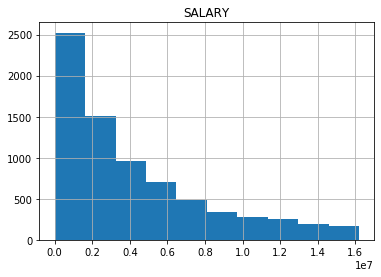

In [9]:
# plot the salary distribution
_ = df.hist('SALARY')

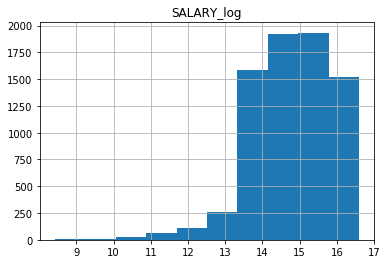

In [10]:
# take log transformation for salary
df['SALARY_log'] = np.log(df['SALARY'])

# plot the log salary distribution
_ = df.hist('SALARY_log')

In [13]:
# split features and raw target
X = df[[
    'GP', 'MIN', 'FG_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A',
    'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 
    'REB', 'AST', 'BLK', 'STL', 'PF', 'TOV', 'PTS', 'YEAR']]
y = df['SALARY']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size = 0.25, random_state = 57)

In [14]:
# split features and log salary
X = df[[
    'GP', 'MIN', 'FG_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A',
    'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 
    'REB', 'AST', 'BLK', 'STL', 'PF', 'TOV', 'PTS', 'YEAR']]
y = df['SALARY_log']

# train test split for log salary
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X, y, 
    test_size = 0.25, random_state = 57)

## Model

---

###### Linear Regression

In [16]:
X_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_const)
res = model.fit()
pred = res.predict(sm.add_constant(X_test))
print('Mean Absolute Error is ', mean_absolute_error(y_test, pred))
print('\nResult Summary:')
_ = print(res.summary2())

Mean Absolute Error is  2259101.107668117

Result Summary:
                          Results: Ordinary least squares
Model:                   OLS                   Adj. R-squared:          0.422      
Dependent Variable:      SALARY                AIC:                     181800.3244
Date:                    2020-11-18 20:16      BIC:                     181946.0737
No. Observations:        5569                  Log-Likelihood:          -90878.    
Df Model:                21                    F-statistic:             194.6      
Df Residuals:            5547                  Prob (F-statistic):      0.00       
R-squared:               0.424                 Scale:                   8.7777e+12 
-----------------------------------------------------------------------------------
             Coef.         Std.Err.      t    P>|t|       [0.025         0.975]    
-----------------------------------------------------------------------------------
const   -102467671.8944 15776114.3920 -6.49

/Users/yangzibin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


###### Linear Regression - Log Transformation

In [17]:
X_const = sm.add_constant(X_log_train)
model = sm.OLS(y_log_train, X_const)
res = model.fit()
pred = res.predict(sm.add_constant(X_log_test))
print('Mean Absolute Error is ', mean_absolute_error(np.e**y_log_test, np.e**pred))
print('\nResult Summary:')
_ = print(res.summary2())

Mean Absolute Error is  2196677.67230888

Result Summary:
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.380     
Dependent Variable: SALARY_log       AIC:                14100.0966
Date:               2020-11-18 20:16 BIC:                14245.8460
No. Observations:   5569             Log-Likelihood:     -7028.0   
Df Model:           21               F-statistic:        163.3     
Df Residuals:       5547             Prob (F-statistic): 0.00      
R-squared:          0.382            Scale:              0.73350   
---------------------------------------------------------------------
           Coef.     Std.Err.      t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------
const     -11.6763     4.5605   -2.5603   0.0105   -20.6166   -2.7360
GP          0.0047     0.0007    6.9132   0.0000     0.0034    0.0061
MIN         0.0333     0.0043    7.6595   0.0000     0.0248    0.0

/Users/yangzibin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


###### Random Forest

In [18]:
# cross validation for logistic regression
def rf_cv(X_tr, y_tr, X_te, y_te, n_splits = 10, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        rf = RandomForestRegressor(n_estimators = n, max_depth = 10, random_state = 57)
        rf.fit(train_features, train_labels)
        
        oof[vi] = rf.predict(valid_features)
        folds[ti] = rf.predict(train_features)
        t_fold += rf.predict(X_te)
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(train_labels, folds[ti]))
        mae_valid.append(mean_absolute_error(valid_labels, oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(y_te, np.round(t_fold / n_splits)))
    
    return mae_train, mae_valid, mae_test

In [19]:
# grid search for best model based on MAE score
mae_train_list = []
mae_valid_list = []
mae_test_list = []
N = []
X_train.reset_index(drop = True, inplace = True)
for n in [50, 100, 150, 200]:
    mae_train, mae_valid, mae_test = rf_cv(X_train,  y_train.values, X_test, y_test.values, n_splits = 5, n = n)
    N.append(n)
    mae_train_list.append(np.mean(mae_train))
    mae_valid_list.append(np.mean(mae_valid))
    mae_test_list.append(mae_test)
    
print('Best Model:')
print('N = ', N[mae_valid_list.index(np.max(mae_valid_list))])
print('Validation MAE: ', mae_valid_list[mae_valid_list.index(np.max(mae_valid_list))])
print('Testing MAE: ', mae_test_list[mae_valid_list.index(np.max(mae_valid_list))][0])

Best Model:
N =  50
Validation MAE:  2143622.9538933584
Testing MAE:  2177314.188476037


###### Random Forest - Log Transformation

In [20]:
# cross validation for logistic regression
def rf_log_cv(X_tr, y_tr, X_te, y_te, n_splits = 10, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        rf = RandomForestRegressor(n_estimators = n, max_depth = 10, random_state = 57)
        rf.fit(train_features, train_labels)
        
        oof[vi] = rf.predict(valid_features)
        folds[ti] = rf.predict(train_features)
        t_fold += rf.predict(X_te)
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(np.e**train_labels, np.e**folds[ti]))
        mae_valid.append(mean_absolute_error(np.e**valid_labels, np.e**oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(np.e**y_te, np.e**(np.round(t_fold / n_splits))))
    
    return mae_train, mae_valid, mae_test

In [21]:
# grid search for best model based on MAE score
mae_train_list = []
mae_valid_list = []
mae_test_list = []
N = []
X_log_train.reset_index(drop = True, inplace = True)
for n in [50, 100, 150, 200]:
    mae_train, mae_valid, mae_test = rf_log_cv(X_log_train,  y_log_train.values, X_log_test, y_log_test.values, n_splits = 5, n = n)
    N.append(n)
    mae_train_list.append(np.mean(mae_train))
    mae_valid_list.append(np.mean(mae_valid))
    mae_test_list.append(mae_test)

print('Best Model:')
print('N = ', N[mae_valid_list.index(np.max(mae_valid_list))])
print('Validation MAE: ', mae_valid_list[mae_valid_list.index(np.max(mae_valid_list))])
print('Testing MAE: ', mae_test_list[mae_valid_list.index(np.max(mae_valid_list))][0])

Best Model:
N =  50
Validation MAE:  2144783.145113663
Testing MAE:  2303783.263347635


## Feature Importance

---

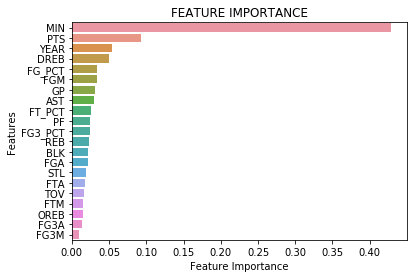

In [24]:
# select the best performance model
rf = RandomForestRegressor(n_estimators = 50, max_depth = 10, random_state = 57)
rf.fit(X_train,  y_train.values)

# dataframe for feature importance and feature names
feature_importance = np.array(rf.feature_importances_)
features = np.array(X_train.columns)
fi_df = pd.DataFrame({'features':features,'feature_importance':feature_importance})

# sort the dataframe by feature importance
fi_df.sort_values(by=['feature_importance'], ascending = False , inplace = True)


# plot bar chart
sns.barplot(fi_df['feature_importance'], fi_df['features'])
plt.title('FEATURE IMPORTANCE')
plt.xlabel('Feature Importance')
_ = plt.ylabel('Features')

The top three important features are minutes played per game, points per game and year.

## Reasons of Large MAE

---

In [25]:
# make predictions for X_test
pred = pd.DataFrame({'prediction': rf.predict(X_test)})
X_test_temp = X_test.reset_index(drop = True)
y_test_temp = y_test.reset_index(drop = True)

In [26]:
# compute the difference of actual salary and prediction
result = pd.concat([X_test_temp, pred, y_test_temp], axis = 1)
result['diff'] = result['SALARY'] - result['prediction']
result['diff'].describe()

count    1.857000e+03
mean    -2.201246e+04
std      3.015243e+06
min     -9.521163e+06
25%     -1.584773e+06
50%     -4.585154e+05
75%      1.359367e+06
max      1.371287e+07
Name: diff, dtype: float64

In [27]:
# get top 10 observations with the most salary and prediction difference

# create name list
names = []
# get player names
for i in result.sort_values('diff').index[-10:].values:
    j = int(X_test[i:i+1].index.values)
    names.append(df[j:j + 1]['PLAYER_NAME'].values[0])

# create top 10 overvalued paler dataframe
top_10_overvalued = result.sort_values('diff')[-10:].reset_index(drop = True)
names = pd.DataFrame({'PLAYER_NAME': names})
top_10_overvalued = pd.concat([names, top_10_overvalued], axis = 1)

In [29]:
top_10_overvalued[['PLAYER_NAME', 'MIN', 'PTS', 'YEAR', 'SALARY', 'prediction', 'diff']]

,PLAYER_NAME,MIN,PTS,YEAR,SALARY,prediction,diff
0,Kenyon Martin,32.0,11.7,2008,15852511.0,6.127674e+06,9.724837e+06
1,Tim Thomas,27.3,12.0,2004,13975000.0,3.997419e+06,9.977581e+06
2,Shawn Kemp,15.9,6.5,2000,12770000.0,2.725800e+06,1.004420e+07
3,Courtney Lee,14.4,4.5,2019,12759670.0,2.651728e+06,1.010794e+07
4,Vin Baker,24.5,9.8,2003,14625000.0,3.702384e+06,1.092262e+07
5,Timofey Mozgov,20.4,7.4,2016,16000000.0,5.075336e+06,1.092466e+07
6,Ian Mahinmi,14.9,4.8,2017,15944154.0,4.291777e+06,1.165238e+07
7,James Johnson,19.4,8.4,2019,15349400.0,3.184248e+06,1.216515e+07
8,Brandon Knight,18.5,7.3,2019,15643750.0,3.094426e+06,1.254932e+07
9,Vin Baker,7.5,1.3,2004,15750000.0,2.037129e+06,1.371287e+07


Vin Baker has his worst performance in 2004 - 2005 season while he still has an annual salary over 10 million in 2005. He ends his professional career in 2006.

Potential reasons why some palyers are overvalued:

1. Some of the palyers may have contracts with the teams for several consecutive years, where the salaries do not change a lot by their performance.
2. Although some players do not have fancy stats in some seasons, the team coach sees their potential or thinks they may be a good fit for the whole team.
3. Players who are super famous tend to have higher salaries.

In [30]:
# get top 10 observations with the most prediction and salary difference

# create name list
names = []
for i in result.sort_values('diff').index[:10].values:
    j = int(X_test[i:i+1].index.values)
    names.append(df[j:j + 1]['PLAYER_NAME'].values[0])
    
# create top 10 undervalued paler dataframe
top_10_undervalued = result.sort_values('diff')[:10].reset_index(drop = True)
names = pd.DataFrame({'PLAYER_NAME': names})
top_10_undervalued = pd.concat([names, top_10_undervalued], axis = 1)

In [32]:
top_10_undervalued[['PLAYER_NAME', 'MIN', 'PTS', 'YEAR', 'SALARY', 'prediction', 'diff']]

,PLAYER_NAME,MIN,PTS,YEAR,SALARY,prediction,diff
0,Dwyane Wade,38.7,24.1,2004,3031920.0,1.255308e+07,-9.521163e+06
1,Michael Jordan,34.8,22.9,2001,1030000.0,1.054219e+07,-9.512187e+06
2,Dwyane Wade,38.6,27.2,2005,3841443.0,1.326234e+07,-9.420897e+06
3,Rudy Gobert,31.7,9.1,2015,2121288.0,1.037129e+07,-8.250006e+06
4,Chris Bosh,39.3,22.5,2005,4235220.0,1.246208e+07,-8.226862e+06
5,Allen Iverson,36.7,17.5,2008,650686.0,8.724110e+06,-8.073424e+06
6,Kevin Martin,33.4,20.0,2014,200600.0,8.264081e+06,-8.063481e+06
7,JaKarr Sampson,31.8,20.0,2018,1620564.0,9.661164e+06,-8.040600e+06
8,Brook Lopez,36.9,18.8,2009,2413320.0,1.028212e+07,-7.868800e+06
9,Jose Calderon,28.1,7.6,2015,247991.0,7.988665e+06,-7.740674e+06


Dwyane Wade was a new player in 2004, 2005. That's why he had a low salary but great performance. His salary goes up to 13 million in 2006.

Michael Jordan is a legend. Although he retired in 2003, his stats in 2001 are above the NBA average.

Quantifying or collecting the potential features stated above is not feasible. We conclude that player performance data plays a very import role in predicting salary but the model could be improved by introduing new features.

Besides, our model can be used to determine whether a player is overvalued or undervalued based on his previous year's performance and current year's salary.